In [1]:
import time
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pathlib
import warnings
import seaborn as sns
from skimage import io

### Set up file paths for data handling

In [2]:
base_folder = pathlib.Path('/Volumes/LaCie/_2021_03_screen/')
manual_analysis_data_folder = base_folder.joinpath('manual_counts')
automated_analysis_data_folder = base_folder.joinpath('_2021_03_automated_results')
image_folder = base_folder.joinpath('crops_4manual')
figure_folder = base_folder.joinpath('Figures')

### Read in the metadata associated with the annotated images

In [3]:
metadata = pd.read_csv(base_folder.joinpath('2103_data_unblinded.csv'),  index_col=0)

### Clean up and add image dimensions
<p>Dyanmic cropping results in images of variable width. As a result we need to be sure that the dimensions being used to calculate the chemotaxis index are consistent for both automated and manual annotation methods. Images were previously cropped for manual annotation. These previously cropped images are being measured in the chunk of code below</p>

In [5]:
analysis_summary = []
for image in image_folder.glob('NPP*.tif'):
    image_id = image.stem[:-3]
    well_id = image.stem[-2:]
    img = io.imread(image)
    dims = img.shape

    row = metadata.loc[(metadata['File Name'] == image_id) & 
                               (metadata['WellNo'] == well_id)]
    row['Width']= dims[1]
    analysis_summary.append(row)
analysis_summary = pd.concat(analysis_summary, sort=True)

/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [6]:
analysis_summary.head()

,Chemotaxis,Compound,Compound Name,File Name,Plate ID,Slot,Strain,Total Worms,Well,WellNo,Width
192,0.032028,65,Piperitenone,NPP_210319_POST_007,NPP_210319_017,1,NaN,326,A,1A,3045
195,0.227586,66,Apigenin,NPP_210319_POST_007,NPP_210319_017,1,NaN,341,B,1B,3022
198,0.076336,67,Oleanolic Acid,NPP_210319_POST_007,NPP_210319_017,1,NaN,289,C,1C,3044
201,0.121662,68,Delsoline,NPP_210319_POST_007,NPP_210319_017,1,NaN,376,D,1D,3047
204,0.124638,69,Ajmalicine,NPP_210319_POST_007,NPP_210319_018,2,NaN,401,A,2A,3106


### Aggregate and clean all of the manual annotations

In [7]:
results_files = manual_analysis_data_folder.glob('[!_.]*.csv')

manual_analysis_results = []
for file in results_files:
    prefix = file.stem[:3]
    ## Some of the data was saved in tabular format and needs to be handled 
    if prefix != 'SYR':
        this_experiment_df = pd.read_csv(file,  index_col=0)
        image_id = file.stem[4:-3]
        this_experiment_df['file_id'] = image_id
        well_id = file.stem[-2:].upper()

        this_experiment_df['WellNo'] = well_id

        manual_analysis_results.append(this_experiment_df)
    else:
        this_experiment_df = pd.read_csv(file, sep = '\t', index_col=0)
        image_id = file.stem[4:-3]
        this_experiment_df['file_id'] = image_id
        well_id = file.stem[-2:].upper()

        this_experiment_df['WellNo'] = well_id

        manual_analysis_results.append(this_experiment_df)
manual_analysis_results = pd.concat(manual_analysis_results, sort=True)
manual_analysis_results.head()

,Mean,WellNo,X,Y,file_id
,,,,,
1,NaN,1B,52.0,559.0,210319_POST_002
2,NaN,1B,101.0,502.0,210319_POST_002
3,NaN,1B,48.0,452.0,210319_POST_002
4,NaN,1B,59.0,446.0,210319_POST_002
5,NaN,1B,229.0,343.0,210319_POST_002


In [8]:
manual_analysis_results.to_csv(base_folder.joinpath('All_x.csv'))

### Calculating the chemotaxis index from the manually annotated images

In [28]:

manual_analysis_summary = analysis_summary.copy()
manual_analysis_summary = manual_analysis_summary.drop(['Chemotaxis', 'Strain', 'Total Worms'], axis=1)

for index, well in manual_analysis_summary.iterrows():
    width = well['Width']
    solvent_limit = int(width*5/9)
    compount_limit = int(width*4/9)
    image_id = well['File Name']
    file_id = image_id[4:]
    well_id = well['WellNo']
    
    # Find number of worms in each region
    compound_side_worms = manual_analysis_results.loc[
            (manual_analysis_results['file_id'] == file_id) &
            (manual_analysis_results['WellNo'] == well_id) &
            (manual_analysis_results['X'] <= compount_limit)].shape[0]
    manual_analysis_summary.loc[index, 'worms_on_compound_side'] = compound_side_worms
    
    solvent_side_worms = manual_analysis_results.loc[
            (manual_analysis_results['file_id'] == file_id) &
            (manual_analysis_results['WellNo'] == well_id) &
            (manual_analysis_results['X'] >= solvent_limit)].shape[0]
    manual_analysis_summary.loc[index, 'worms_on_solvent_side'] = solvent_side_worms
    
    neutral_worms = manual_analysis_results.loc[
            (manual_analysis_results['file_id'] == file_id) &
            (manual_analysis_results['WellNo'] == well_id) &
            (manual_analysis_results['X'] <= solvent_limit) &
            (manual_analysis_results['X'] >= compount_limit)].shape[0]
    manual_analysis_summary.loc[index, 'worms_on_neutral_side'] = neutral_worms
    
    manual_analysis_summary.loc[index, 'Total Worms'] = (compound_side_worms + solvent_side_worms + neutral_worms)

    # Calculate chemotaxis index (and centroid for good measure)
    if compound_side_worms != 0 and solvent_side_worms != 0:
        manual_analysis_summary.loc[index, 'Chemotaxis Index'] = ((compound_side_worms - solvent_side_worms) / 
                                                   (compound_side_worms + solvent_side_worms))
    

manual_analysis_summary['analysis_method'] = 'manual'
manual_analysis_summary.head()

KeyError: "['Chemotaxis' 'Strain'] not found in axis"

### A plot of summary statistics for both manual and automated annotations

/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Manual counts:
 count     96.000000
mean     293.458333
std      104.906366
min       95.000000
25%      199.500000
50%      300.500000
75%      372.000000
max      549.000000
Name: mean, dtype: float64
Automated counts:
 count     96.000000
mean     241.281250
std       78.214106
min      104.000000
25%      174.000000
50%      247.500000
75%      300.500000
max      405.000000
Name: Total Worms, dtype: float64


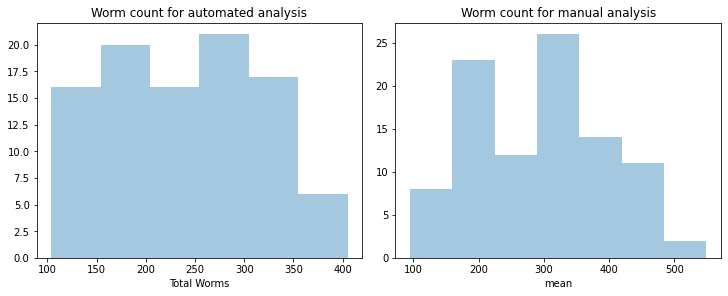

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), constrained_layout=True)

axes[0] = sns.distplot(analysis_summary['Total Worms'], kde=False,
                      ax=axes[0])
axes[0].set_title('Worm count for automated analysis')


axes[1] =  sns.distplot(
    manual_analysis_summary.groupby(
        ['Plate ID', 'WellNo']).describe()['Total Worms']['mean'],
    kde=False, ax=axes[1])
axes[1].set_title('Worm count for manual analysis')

print('Manual counts:\n',
      manual_analysis_summary.groupby(['Plate ID', 'WellNo']).describe()['Total Worms']['mean'].describe())
print('Automated counts:\n',
      analysis_summary['Total Worms'].describe())


### Cleaning up automated annotation data and combing it with manually annotated data for plotting

In [13]:
analysis_summary = analysis_summary.drop(['Strain'], axis=1)
analysis_summary = analysis_summary.rename(columns={'Chemotaxis': 'Chemotaxis Index'})
analysis_summary['analysis_method'] = 'auto'
analysis_summary.head()

,Chemotaxis Index,Compound,Compound Name,File Name,Plate ID,Slot,Total Worms,Well,WellNo,Width,analysis_method
192,0.032028,65,Piperitenone,NPP_210319_POST_007,NPP_210319_017,1,326,A,1A,3045,auto
195,0.227586,66,Apigenin,NPP_210319_POST_007,NPP_210319_017,1,341,B,1B,3022,auto
198,0.076336,67,Oleanolic Acid,NPP_210319_POST_007,NPP_210319_017,1,289,C,1C,3044,auto
201,0.121662,68,Delsoline,NPP_210319_POST_007,NPP_210319_017,1,376,D,1D,3047,auto
204,0.124638,69,Ajmalicine,NPP_210319_POST_007,NPP_210319_018,2,401,A,2A,3106,auto


In [14]:
combined_results = pd.concat([manual_analysis_summary[['File Name', 'Plate ID',
                                       'WellNo',
                                       'Compound',
                                       'Compound Name',
                                       'Total Worms',
                                       'Chemotaxis Index',
                                       'analysis_method',
                                        'Width']].copy(),
                              analysis_summary[['File Name', 'Plate ID',
                                       'WellNo',
                                       'Compound',
                                       'Compound Name',
                                       'Total Worms',
                                       'Chemotaxis Index',
                                       'analysis_method',
                                        'Width']].copy()])
combined_results.head()

,File Name,Plate ID,WellNo,Compound,Compound Name,Total Worms,Chemotaxis Index,analysis_method,Width
192,NPP_210319_POST_007,NPP_210319_017,1A,65,Piperitenone,383.0,0.045977,manual,3045
195,NPP_210319_POST_007,NPP_210319_017,1B,66,Apigenin,443.0,0.432161,manual,3022
198,NPP_210319_POST_007,NPP_210319_017,1C,67,Oleanolic Acid,320.0,0.105263,manual,3044
201,NPP_210319_POST_007,NPP_210319_017,1D,68,Delsoline,487.0,0.280702,manual,3047
204,NPP_210319_POST_007,NPP_210319_018,2A,69,Ajmalicine,459.0,0.181818,manual,3106


### Generating plots to visualize the performance of the worm counting algorithm

In [21]:
worms_by_manual_count = []
for index, manual_count in manual_analysis_summary.iterrows():
    this_manual_analysis = {
        'file_name': manual_count['File Name'],
        'well_id': manual_count['WellNo'],
        'compound': manual_count['Compound Name'],
        'total_worms_manual': manual_count['Total Worms'],
        'manual_ci': manual_count['Chemotaxis Index'],
        'total_worms_auto': analysis_summary.loc[
            (analysis_summary['File Name']==manual_count['File Name']) &
            (analysis_summary['WellNo']==manual_count['WellNo'])]['Total Worms'].values[0],
        'auto_ci': analysis_summary.loc[
            (analysis_summary['File Name']==manual_count['File Name']) &
            (analysis_summary['WellNo']==manual_count['WellNo'])]['Chemotaxis Index'].values[0]}
    worms_by_manual_count.append(this_manual_analysis)
worm_count_df = pd.DataFrame(worms_by_manual_count)

In [23]:
worm_count_df.head()

,auto_ci,compound,file_name,manual_ci,total_worms_auto,total_worms_manual,well_id
0,0.032028,Piperitenone,NPP_210319_POST_007,0.045977,326,383.0,1A
1,0.227586,Apigenin,NPP_210319_POST_007,0.432161,341,443.0,1B
2,0.076336,Oleanolic Acid,NPP_210319_POST_007,0.105263,289,320.0,1C
3,0.121662,Delsoline,NPP_210319_POST_007,0.280702,376,487.0,1D
4,0.124638,Ajmalicine,NPP_210319_POST_007,0.181818,401,459.0,2A


##### Total Worms: Manual vs Automated

LinregressResult(slope=0.717643236213597, intercept=30.682861972818188, rvalue=0.9625545540895885, pvalue=4.393520454251374e-55, stderr=0.02084633383610998)


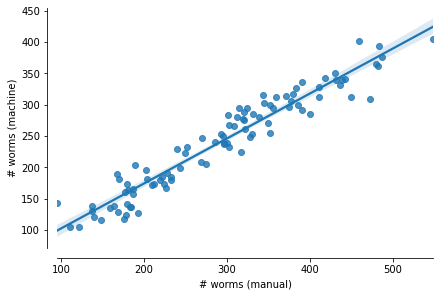

In [24]:
fig, ax = plt.subplots(constrained_layout=True)
sns.regplot(x='total_worms_manual', y='total_worms_auto', ax=ax,
                     data=worm_count_df)
ax.set_ylabel('# worms (machine)')
ax.set_xlabel('# worms (manual)')
sns.despine(offset=10)
fig.savefig(base_folder.joinpath('total_worms_man_vs_machine.pdf'))

fit_results = stats.linregress(
    worm_count_df['total_worms_manual'], worm_count_df['total_worms_auto'])
print(fit_results)


##### Chemotaxis Index: Manual vs Automated

LinregressResult(slope=0.8871484052980022, intercept=-0.0064106776786123365, rvalue=0.9791277531167379, pvalue=7.537191415777796e-67, stderr=0.018993915636667143)


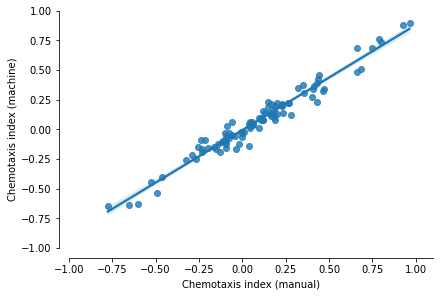

In [25]:
fig, ax = plt.subplots(constrained_layout=True)
ax = sns.regplot(x='manual_ci', y='auto_ci', ax=ax,
                     data=worm_count_df)
ax.set_ylabel('Chemotaxis index (machine)')
ax.set_xlabel('Chemotaxis index (manual)')
ax.set_ylim((-1, 1))
ax.set_xlim((-1, 1.1))
sns.despine(offset=10)

fig.savefig(base_folder.joinpath('ci_man_vs_machine.pdf'))

fit_results = stats.linregress(
    worm_count_df['manual_ci'], worm_count_df['auto_ci'])
print(fit_results)

##### Worm Count vs Chemotaxis Index Difference (Automated - Manual) 

LinregressResult(slope=-9.789239067229535e-05, intercept=0.011661353656183256, rvalue=-0.14617116749231182, pvalue=0.155298360188205, stderr=6.833346449681215e-05)


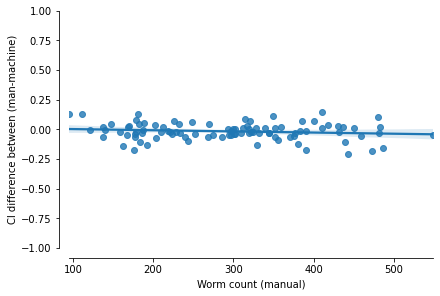

In [27]:
worm_count_df['ci_difference'] = worm_count_df['auto_ci'] - worm_count_df['manual_ci']
fig, ax = plt.subplots(constrained_layout=True)
ax.set_ylim((-1, 1))
ax = sns.regplot(x='total_worms_manual', y='ci_difference', ax=ax,
                     data=worm_count_df)
ax.set_ylabel('CI difference between (man-machine)')
ax.set_xlabel('Worm count (manual)')
sns.despine(offset=10)

fig.savefig(base_folder.joinpath('ci_diff_vs_machine_total.pdf'))

fit_results = stats.linregress(
    worm_count_df['total_worms_manual'], worm_count_df['ci_difference'])
print(fit_results)

Text(0.5, 1.0, 'N2 chemotaxis by image analysis method')

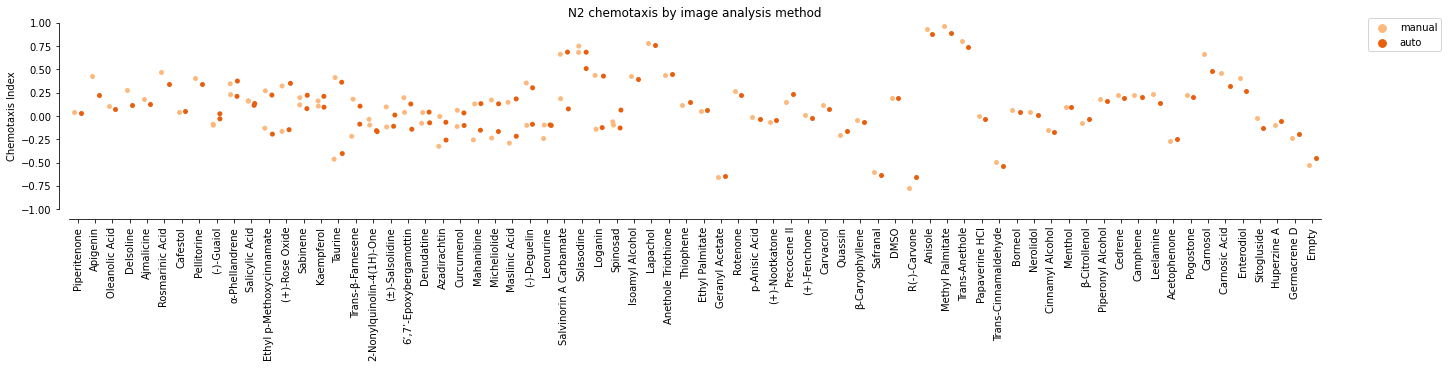

In [15]:
fig, ax = plt.subplots(figsize=(20, 5), constrained_layout=True)
sns.stripplot(x='Compound Name', y='Chemotaxis Index', ax=ax, dodge=True, #style='analysis_method',
              hue='analysis_method', marker='o', palette='Oranges',
              data=combined_results)

ax.set_xlabel('')
ax.set_ylabel('Chemotaxis Index')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylim((-1, 1))
sns.despine(offset=10)
plt.xticks(rotation=90)
ax.set_title('N2 chemotaxis by image analysis method')

#fig.savefig('../N2_chemotaxis_results_auto_vs_manual.pdf')